# Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import nltk
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense,Dropout,BatchNormalization, Input
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, GlobalMaxPooling1D

# Membuka Dataset Hasil Stemming

In [2]:
df = pd.read_csv('dataset_swch_roberta_ayame.csv',delimiter=';')
df

,Unnamed: 0,Stemming,label
0,0,shelaemeliana sehat iya sandwich generation,Neutral
1,1,film rumah swet loan recomended gusy nonton ta...,Neutral
2,2,tanyakanrl teman sandwich generation hedon,Neutral
3,3,kabar iya kakak kakak garuda soft spoken sandw...,Neutral
4,4,film bagus kali menang huhu misuhmisuhinkeluar...,Positive
...,...,...,...
1407,1407,idola perempuanperempuan dady isue sandwich ge...,Neutral
1408,1408,convomf anak of kursus sandwich generation,Neutral
1409,1409,convomf anak of kursus sandwich generation,Neutral
1410,1410,inipita biar enak bada badane suka gel gel san...,Positive


# Pre-Proses Dataset

In [3]:
del df ['Unnamed: 0']
df

,Stemming,label
0,shelaemeliana sehat iya sandwich generation,Neutral
1,film rumah swet loan recomended gusy nonton ta...,Neutral
2,tanyakanrl teman sandwich generation hedon,Neutral
3,kabar iya kakak kakak garuda soft spoken sandw...,Neutral
4,film bagus kali menang huhu misuhmisuhinkeluar...,Positive
...,...,...
1407,idola perempuanperempuan dady isue sandwich ge...,Neutral
1408,convomf anak of kursus sandwich generation,Neutral
1409,convomf anak of kursus sandwich generation,Neutral
1410,inipita biar enak bada badane suka gel gel san...,Positive


In [4]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df

,Stemming,label
0,shelaemeliana sehat iya sandwich generation,Neutral
1,film rumah swet loan recomended gusy nonton ta...,Neutral
2,tanyakanrl teman sandwich generation hedon,Neutral
3,kabar iya kakak kakak garuda soft spoken sandw...,Neutral
4,film bagus kali menang huhu misuhmisuhinkeluar...,Positive
...,...,...
1407,idola perempuanperempuan dady isue sandwich ge...,Neutral
1408,convomf anak of kursus sandwich generation,Neutral
1409,convomf anak of kursus sandwich generation,Neutral
1410,inipita biar enak bada badane suka gel gel san...,Positive


In [5]:
df['label'].value_counts()

,count
label,
Neutral,640
Negative,513
Positive,259


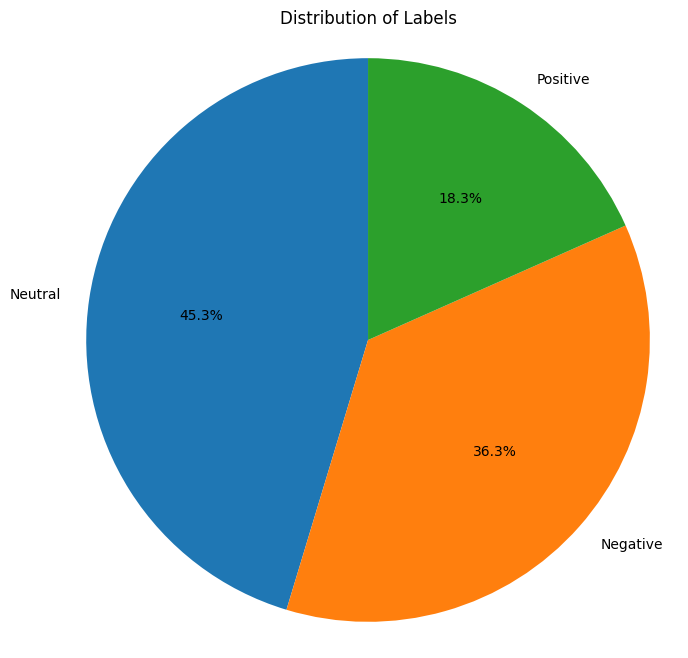

In [6]:
label_counts = df['label'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Labels')
plt.axis('equal')
plt.show()

# Data Augmentasi Untuk Memperkaya Data

In [7]:
import random
import nltk
from nltk.corpus import wordnet

In [8]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
def synonym_replacement(text):
    words = nltk.word_tokenize(text)  # Tokenisasi kalimat menjadi kata-kata
    new_words = words.copy()

    for word in words:
        # Mengambil sinonim dari WordNet
        synonyms = wordnet.synsets(word)
        if synonyms:
            # Ambil satu sinonim secara acak
            synonym = random.choice(synonyms).lemmas()[0].name()  # Ambil sinonim pertama
            new_words = [synonym if w == word else w for w in new_words]

    return ' '.join(new_words)

# Lakukan augmentasi pada dataset
augmented_texts = []
for text in df['Stemming']:
    augmented_texts.append(synonym_replacement(text))

# Buat DataFrame baru untuk menampung teks augmented
augmented_df = pd.DataFrame({
    'Stemming': augmented_texts,
    'label': df['label']  # Tetap menggunakan label asli
})

# Gabungkan dengan DataFrame asli
combined_df = pd.concat([df, augmented_df], ignore_index=True)

# Tampilkan hasil augmentasi
print(combined_df)

                                               Stemming     label
0           shelaemeliana sehat iya sandwich generation   Neutral
1     film rumah swet loan recomended gusy nonton ta...   Neutral
2            tanyakanrl teman sandwich generation hedon   Neutral
3     kabar iya kakak kakak garuda soft spoken sandw...   Neutral
4     film bagus kali menang huhu misuhmisuhinkeluar...  Positive
...                                                 ...       ...
2819  idola perempuanperempuan dady isue sandwich co...   Neutral
2820         convomf anak of kursus sandwich generation   Neutral
2821         convomf anak of kursus sandwich generation   Neutral
2822  inipita biar enak bada badane suka gel gel san...  Positive
2823  mending kost alternating_current not alternati...  Negative

[2824 rows x 2 columns]


Merubah data teks menjadi vektor untuk diolah

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=1000)
X_vectorized = vectorizer.fit_transform(combined_df['Stemming']).toarray()
X_vectorized

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Merubah label menjadi kode numerik

In [11]:
# Konversi label menjadi format numerik
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(combined_df['label'])
y_encoded

array([1, 1, 1, ..., 1, 2, 0])

# Pemerataan Data Minor Agara Data Seimbang untuk Diolah

In [12]:
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
# Terapkan SMOTE pada data vektor
smote = SMOTE(sampling_strategy='minority', random_state=32)
X_smote, y_smote = smote.fit_resample(X_vectorized, y_encoded)
pd.value_counts(y_smote)

<ipython-input-12-6d58dc942d7a>:6: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(y_smote)


,count
1,1280
2,1280
0,1026


<ipython-input-13-2a87eb2dfedc>:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  label_counts_smote = pd.value_counts(y_smote)


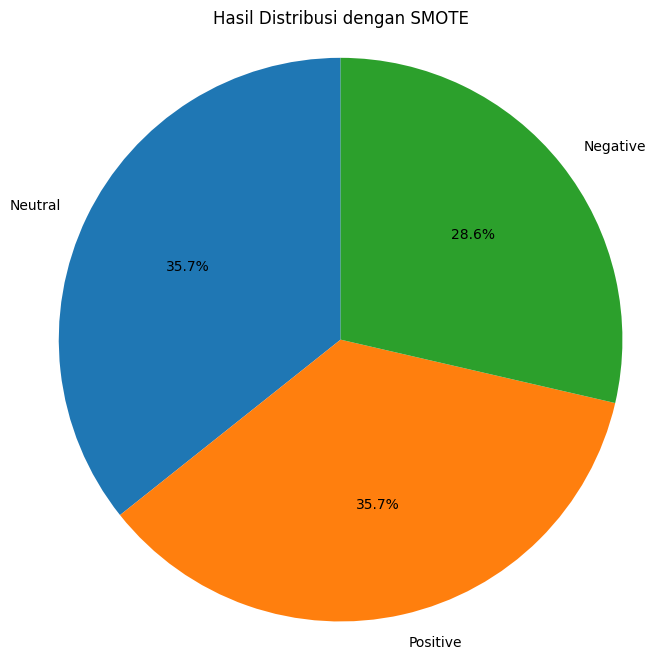

In [13]:
import matplotlib.pyplot as plt

label_counts_smote = pd.value_counts(y_smote)
labels_original = label_encoder.inverse_transform(label_counts_smote.index)

plt.figure(figsize=(8, 8))
plt.pie(label_counts_smote, labels=labels_original, autopct='%1.1f%%', startangle=90)
plt.title('Hasil Distribusi dengan SMOTE')
plt.axis('equal')
plt.show()

In [14]:
from sklearn.utils.class_weight import compute_class_weight
# Hitung class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_smote),
    y=y_smote
)

# Ubah menjadi dictionary agar dapat digunakan dalam `fit`
class_weights = dict(enumerate(class_weights))

print("Class weights:", class_weights)

Class weights: {0: 1.165042235217674, 1: 0.9338541666666667, 2: 0.9338541666666667}


In [15]:
# Split data hasil SMOTE untuk pelatihan dan validasi
X_train, X_val, y_train, y_val = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

Konversi Label hasil split data dan melakukan penyesuaian bentuk pada variabel X agar sesuai untuk input LSTM

In [16]:
# Mengonversi label ke one-hot encoding
y_train = to_categorical(y_train, num_classes=3)
y_val = to_categorical(y_val, num_classes=3)

In [17]:
# Bentuk ulang X_train dan X_val untuk input LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

# Model LSTM

Model untuk melakukan pengujian data dengan melihat perbandingan tiap batch dengan ketentuan menggunakan neuron 100 dan epoch 50 untuk menguji pada ukuran batch 32, 64, 128. Pengujian ini dilakukan sebagai bagian dari hyperparameter tuning untuk memastikan model belajar secara efisien, mencapai generalisasi yang baik, dan memaksimalkan akurasi dalam waktu yang wajar. Hasil akhirnya adalah menemukan ukuran batch yang optimal untuk dataset dan model yang digunakan, serta perangkat keras yang tersedia, agar pelatihan menjadi lebih efektif dan efisien.


Training with batch size: 32 and 100 neurons in LSTM layers.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 62ms/step - accuracy: 0.3854 - loss: 2.2259 - val_accuracy: 0.4248 - val_loss: 1.5742 - learning_rate: 5.0000e-04
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5829 - loss: 1.3890 - val_accuracy: 0.4763 - val_loss: 1.3498 - learning_rate: 5.0000e-04
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7214 - loss: 1.0421 - val_accuracy: 0.7368 - val_loss: 1.1679 - learning_rate: 5.0000e-04
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.7785 - loss: 0.8484 - val_accuracy: 0.8357 - val_loss: 0.9787 - learning_rate: 5.0000e-04
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8323 - loss: 0.7242 - val_accuracy: 0.8593 - val_loss: 0.8094 - learning_rate: 5.0000e-04
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8309 - loss: 0.6861 - val_accuracy: 0.8538 - val_loss: 0.6940 - learning_rate: 5.0000e-04
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.8319

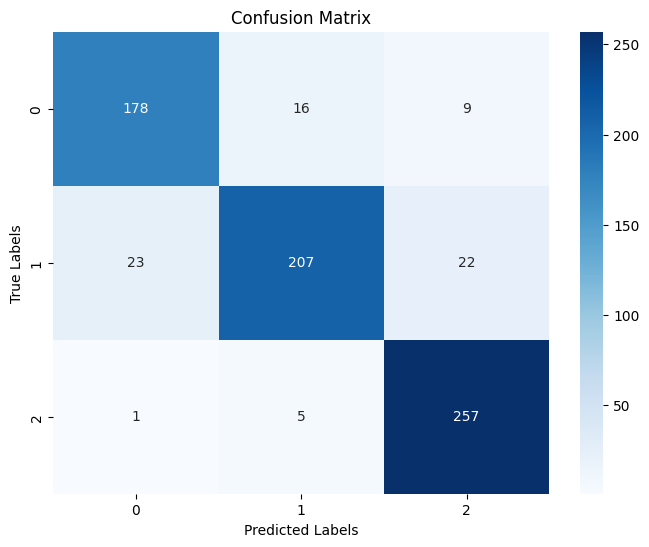

Training and Validation Accuracy for Batch Size 32:


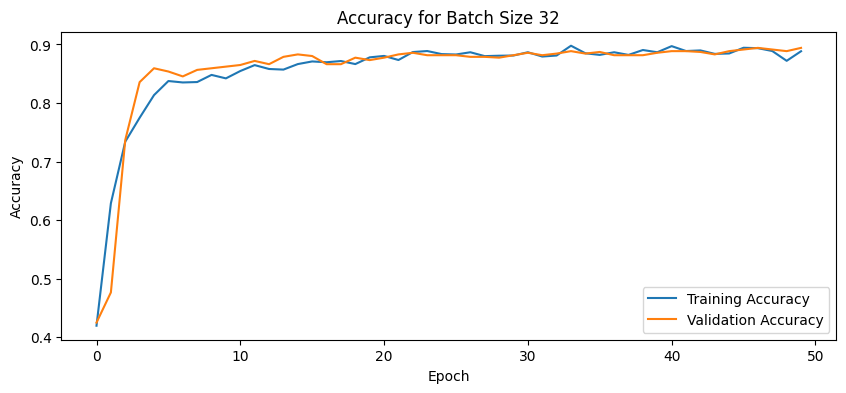

Training and Validation Loss for Batch Size 32:


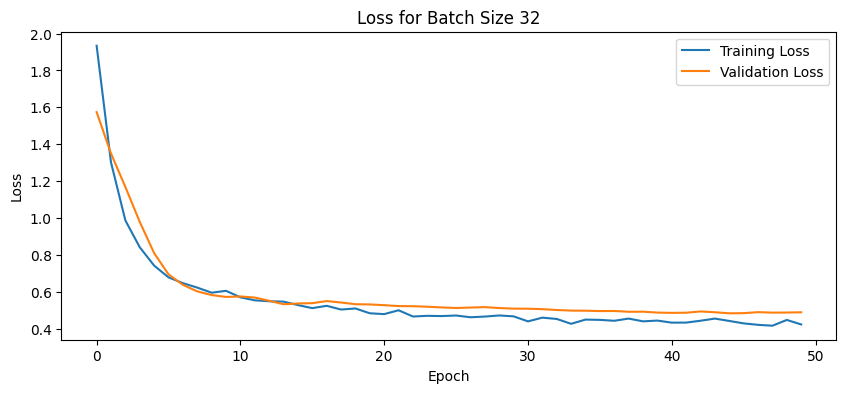


Training with batch size: 64 and 100 neurons in LSTM layers.
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.3727 - loss: 2.3939 - val_accuracy: 0.5042 - val_loss: 1.8712 - learning_rate: 5.0000e-04
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5357 - loss: 1.7057 - val_accuracy: 0.5933 - val_loss: 1.5606 - learning_rate: 5.0000e-04
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6557 - loss: 1.3389 - val_accuracy: 0.5877 - val_loss: 1.4039 - learning_rate: 5.0000e-04
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7675 - loss: 1.0532 - val_accuracy: 0.5961 - val_loss: 1.2908 - learning_rate: 5.0000e-04
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.7994 - loss: 0.8757 - val_accuracy: 0.6560 - val_loss: 1.1922 - learning_rate: 5.0000e-04
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8350 - loss: 0.7697 - val_accuracy: 0.7855 - val_loss: 1.0733 - learning_rate: 5.0000e-04
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8388 - loss: 0.

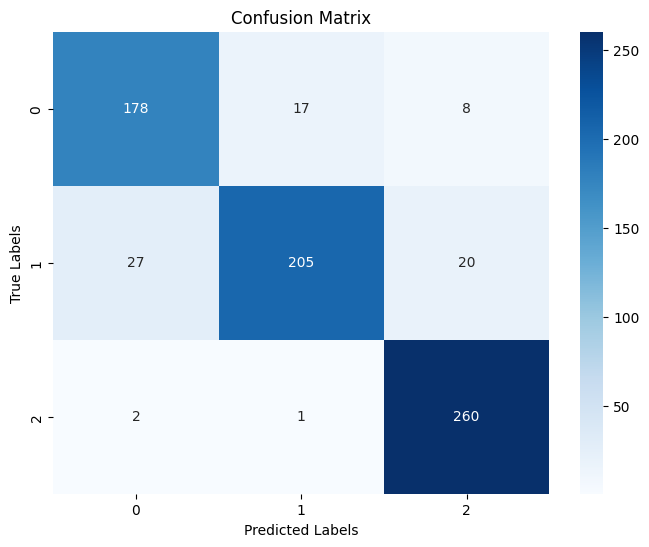

Training and Validation Accuracy for Batch Size 64:


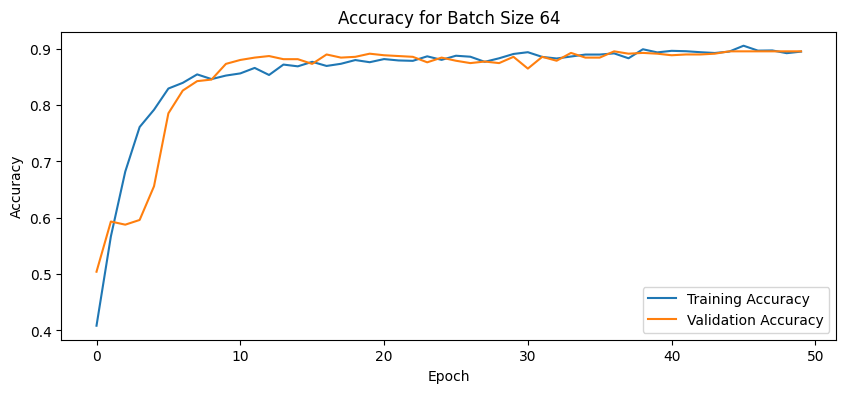

Training and Validation Loss for Batch Size 64:


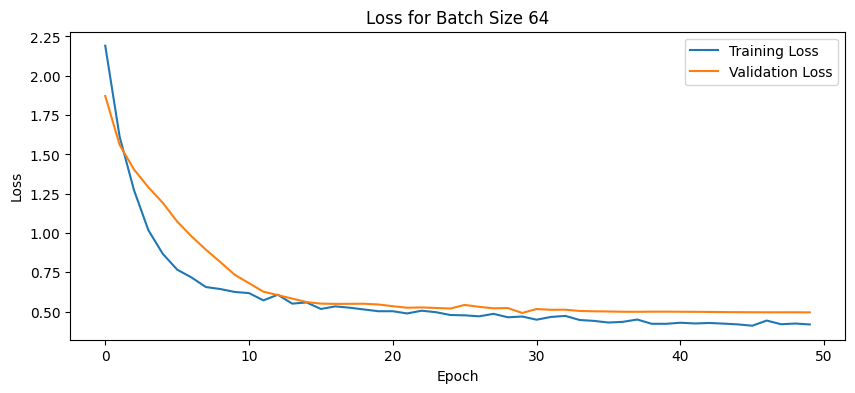


Training with batch size: 128 and 100 neurons in LSTM layers.
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step - accuracy: 0.3490 - loss: 2.5109 - val_accuracy: 0.3760 - val_loss: 2.1660 - learning_rate: 5.0000e-04
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.4516 - loss: 2.0325 - val_accuracy: 0.3663 - val_loss: 1.8575 - learning_rate: 5.0000e-04
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5465 - loss: 1.7003 - val_accuracy: 0.3663 - val_loss: 1.6592 - learning_rate: 5.0000e-04
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6504 - loss: 1.4378 - val_accuracy: 0.3677 - val_loss: 1.5277 - learning_rate: 5.0000e-04
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6894 - loss: 1.2498 - val_accuracy: 0.6058 - val_loss: 1.4293 - learning_rate: 5.0000e-04
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.7508 - loss: 1.0545 - val_accuracy: 0.6448 - val_loss: 1.3476 - learning_rate: 5.0000e-04
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.7968 - loss: 0.

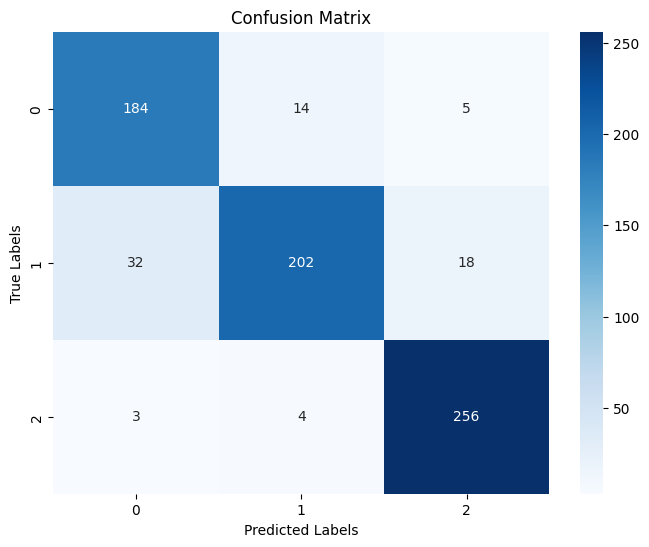

Training and Validation Accuracy for Batch Size 128:


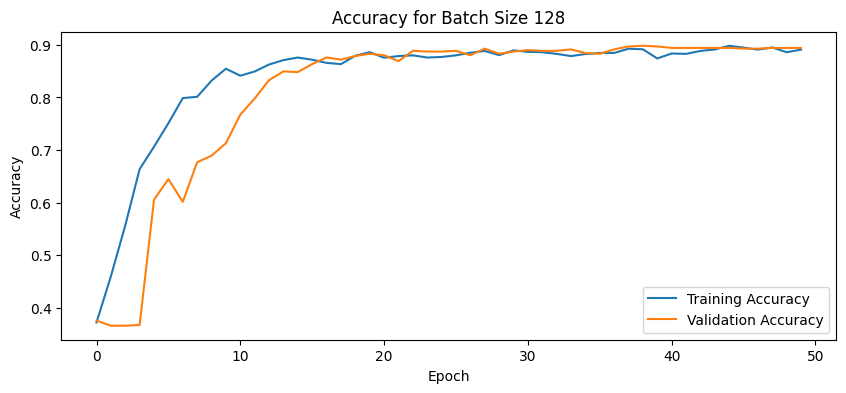

Training and Validation Loss for Batch Size 128:


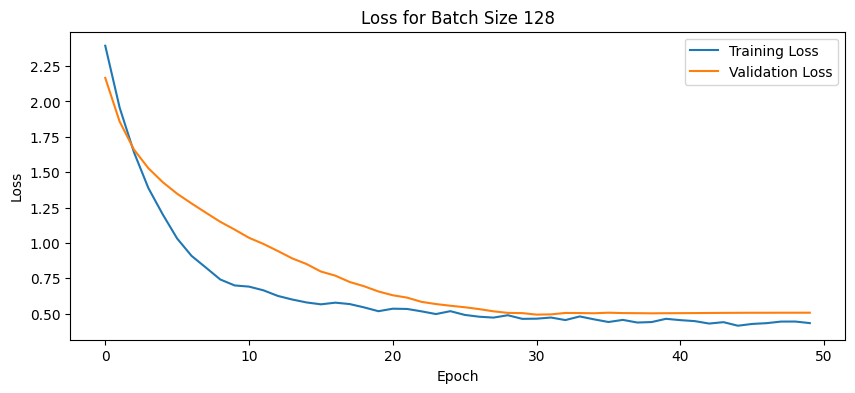

   Batch Size  Validation Loss  Validation Accuracy  Precision    Recall  \
0          32         0.488310             0.894150   0.894654  0.894150   
1          64         0.495673             0.895543   0.896449  0.895543   
2         128         0.507290             0.894150   0.895902  0.894150   

   F1-Score  Support  
0  0.892937    718.0  
1  0.894126    718.0  
2  0.892982    718.0  


In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers
import tensorflow as tf

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Jumlah neuron yang akan digunakan
neurons = 100
batch_sizes = [32, 64, 128]
results = []

for batch_size in batch_sizes:
    print(f"\nTraining with batch size: {batch_size} and {neurons} neurons in LSTM layers.")

    # Kompilasi ulang model untuk setiap batch size
    model_LSTM_batch = tf.keras.models.Sequential([
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(neurons, return_sequences=True, kernel_regularizer=regularizers.l2(0.001), dropout=0.3, input_shape=(X_train.shape[1], X_train.shape[2]))),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),  # Dropout tambahan
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(neurons // 2, kernel_regularizer=regularizers.l2(0.001), dropout=0.3)),
        tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        tf.keras.layers.Dropout(0.5),  # Dropout tambahan
        tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.0001))
    ])

    model_LSTM_batch.compile(
        optimizer=tf.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # ReduceLROnPlateau callback
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

    # Latih model dengan ukuran batch tertentu
    history = model_LSTM_batch.fit(
        X_train, y_train,
        epochs=50,
        batch_size=batch_size,  # Ukuran batch yang berbeda
        validation_data=(X_val, y_val),
        callbacks=[reduce_lr]
    )

    # Evaluasi model
    val_loss, val_accuracy = model_LSTM_batch.evaluate(X_val, y_val)

    # Prediksi label untuk data validasi
    y_val_pred_batch = model_LSTM_batch.predict(X_val)
    y_val_pred_classes_batch = np.argmax(y_val_pred_batch, axis=1)
    y_val_classes_batch = np.argmax(y_val, axis=1)

    # Hitung classification report
    report_lstm_batch = classification_report(y_val_classes_batch, y_val_pred_classes_batch, output_dict=True)

    # Simpan hasil
    results.append({
        'Batch Size': batch_size,
        'Validation Loss': val_loss,
        'Validation Accuracy': val_accuracy,
        'Precision': report_lstm_batch['weighted avg']['precision'],
        'Recall': report_lstm_batch['weighted avg']['recall'],
        'F1-Score': report_lstm_batch['weighted avg']['f1-score'],
        'Support': report_lstm_batch['weighted avg']['support']
    })

    # Plot confusion matrix
    print(f"Confusion Matrix for Batch Size {batch_size}:")
    plot_confusion_matrix(y_val_classes_batch, y_val_pred_classes_batch, labels=[0, 1, 2])

    # Plot training history
    print(f"Training and Validation Accuracy for Batch Size {batch_size}:")
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy for Batch Size {batch_size}')
    plt.legend()
    plt.show()

    print(f"Training and Validation Loss for Batch Size {batch_size}:")
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss for Batch Size {batch_size}')
    plt.legend()
    plt.show()

# Buat DataFrame untuk hasil
results_batch_df = pd.DataFrame(results)

# Tampilkan hasil
print(results_batch_df)

In [19]:
from IPython.display import display, HTML

styled_results = results_batch_df.style.set_properties(**{'text-align': 'center'})
styled_results = styled_results.set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center')]}  # Center-align headers
])
display(HTML(styled_results.to_html()))

,Batch Size,Validation Loss,Validation Accuracy,Precision,Recall,F1-Score,Support
0,32,0.488310,0.894150,0.894654,0.894150,0.892937,718.000000
1,64,0.495673,0.895543,0.896449,0.895543,0.894126,718.000000
2,128,0.507290,0.894150,0.895902,0.894150,0.892982,718.000000


In [20]:
best_result_index = results_batch_df['Validation Accuracy'].idxmax()
best_result_df = results_batch_df.loc[[best_result_index]]

# Display the best result
print("\nBest Result:")
display(best_result_df)


Best Result:


,Batch Size,Validation Loss,Validation Accuracy,Precision,Recall,F1-Score,Support
1,64,0.495673,0.895543,0.896449,0.895543,0.894126,718.0


Pengujian data untuk melihat perbandingan dari neuron 75, 100, 125 dengan mengambil batch size terbaik dari pengujian sebelumnya. Kode ini bertujuan untuk menguji performa model LSTM dengan jumlah neuron berbeda. Hasil eksperimen ini akan membantu memilih konfigurasi terbaik (jumlah neuron yang optimal) berdasarkan performa model pada data validasi.


Training with 75 neurons in LSTM layers.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.3678 - loss: 2.1371 - val_accuracy: 0.3663 - val_loss: 1.7382 - learning_rate: 5.0000e-04
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.4572 - loss: 1.6173 - val_accuracy: 0.4206 - val_loss: 1.4928 - learning_rate: 5.0000e-04
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6049 - loss: 1.3217 - val_accuracy: 0.5167 - val_loss: 1.3720 - learning_rate: 5.0000e-04
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6796 - loss: 1.1230 - val_accuracy: 0.5487 - val_loss: 1.2839 - learning_rate: 5.0000e-04
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7369 - loss: 0.9614 - val_accuracy: 0.6741 - val_loss: 1.1895 - learning_rate: 5.0000e-04
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7893 - loss: 0.8418 - val_accuracy: 0.7340 - val_loss: 1.0885 - learning_rate: 5.0000e-04
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8213

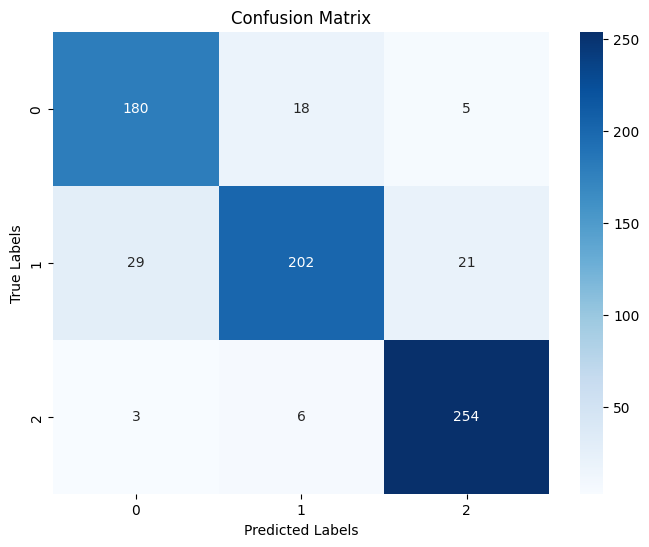

Training and Validation Accuracy for 75 Neurons:


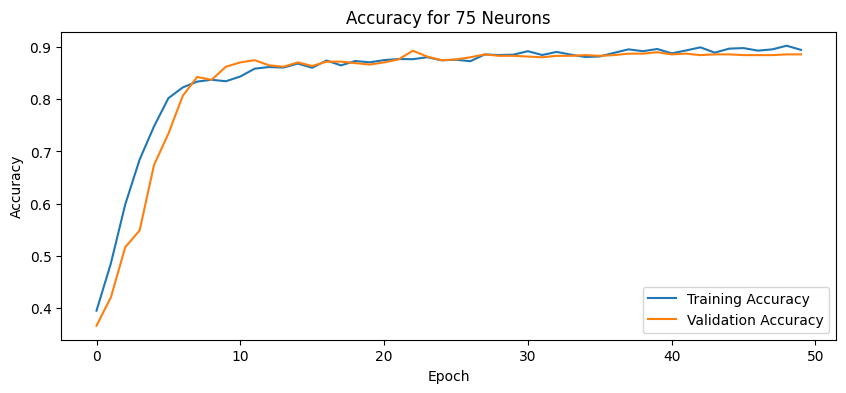

Training and Validation Loss for 75 Neurons:


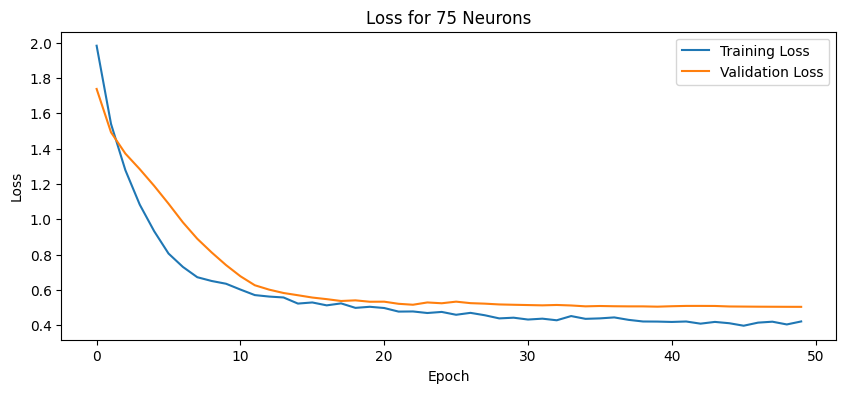


Training with 100 neurons in LSTM layers.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.3678 - loss: 2.3996 - val_accuracy: 0.4373 - val_loss: 1.8875 - learning_rate: 5.0000e-04
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.5338 - loss: 1.7235 - val_accuracy: 0.4123 - val_loss: 1.5791 - learning_rate: 5.0000e-04
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.6527 - loss: 1.3749 - val_accuracy: 0.4847 - val_loss: 1.4284 - learning_rate: 5.0000e-04
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7342 - loss: 1.1044 - val_accuracy: 0.6142 - val_loss: 1.3185 - learning_rate: 5.0000e-04
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7877 - loss: 0.9137 - val_accuracy: 0.6699 - val_loss: 1.2313 - learning_rate: 5.0000e-04
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8087 - loss: 0.8256 - val_accuracy: 0.7103 - val_loss: 1.1152 - learning_rate: 5.0000e-04
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8465

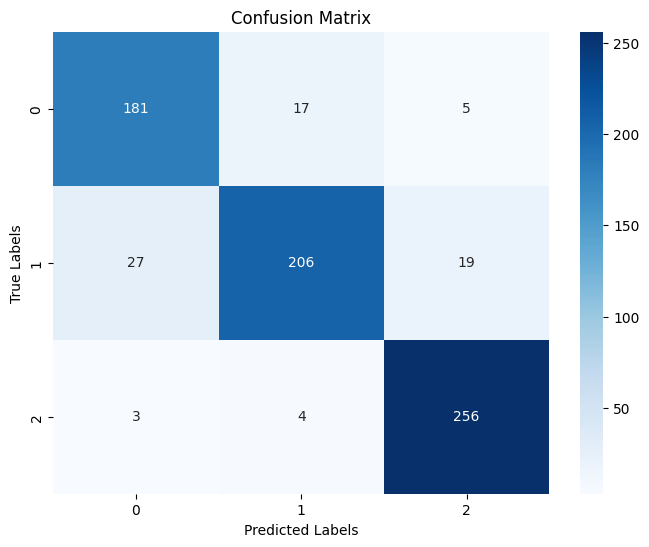

Training and Validation Accuracy for 100 Neurons:


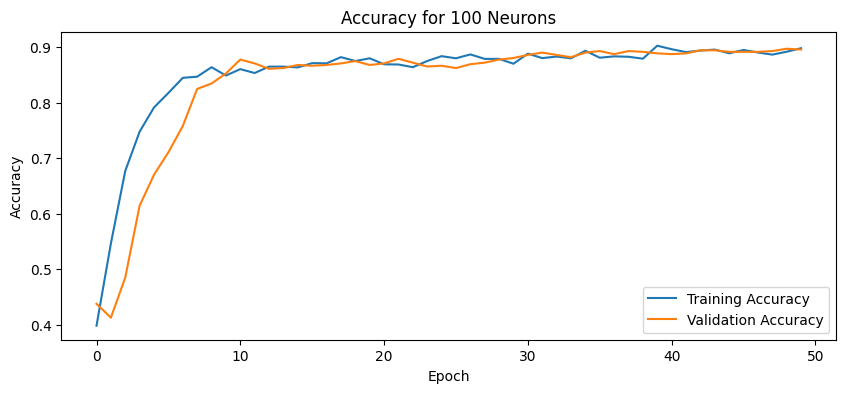

Training and Validation Loss for 100 Neurons:


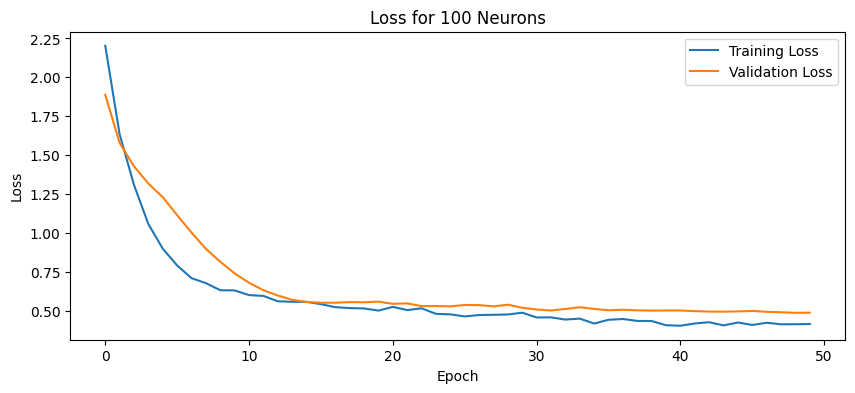


Training with 125 neurons in LSTM layers.
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 104ms/step - accuracy: 0.3909 - loss: 2.6211 - val_accuracy: 0.5084 - val_loss: 1.9803 - learning_rate: 5.0000e-04
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.5692 - loss: 1.7857 - val_accuracy: 0.4638 - val_loss: 1.6004 - learning_rate: 5.0000e-04
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.6728 - loss: 1.3447 - val_accuracy: 0.6435 - val_loss: 1.4094 - learning_rate: 5.0000e-04
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7442 - loss: 1.0444 - val_accuracy: 0.6337 - val_loss: 1.2798 - learning_rate: 5.0000e-04
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.7990 - loss: 0.8517 - val_accuracy: 0.6267 - val_loss: 1.1765 - learning_rate: 5.0000e-04
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.8112 - loss: 0.7755 - val_accuracy: 0.6838 - val_loss: 1.0724 - learning_rate: 5.0000e-04
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.8228 - loss: 0

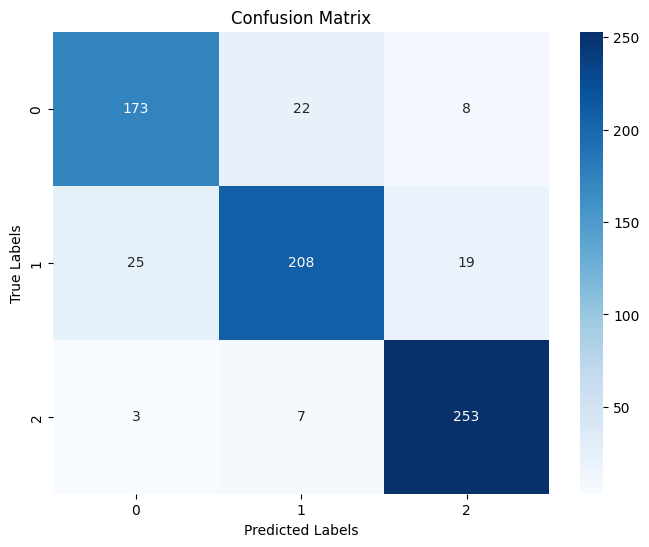

Training and Validation Accuracy for 125 Neurons:


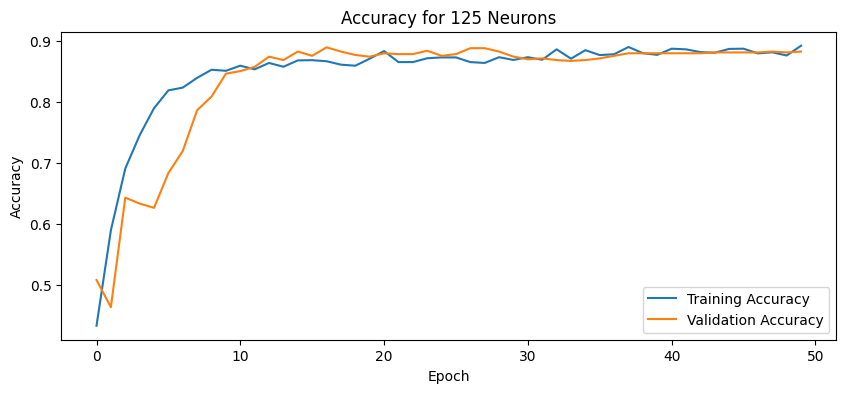

Training and Validation Loss for 125 Neurons:


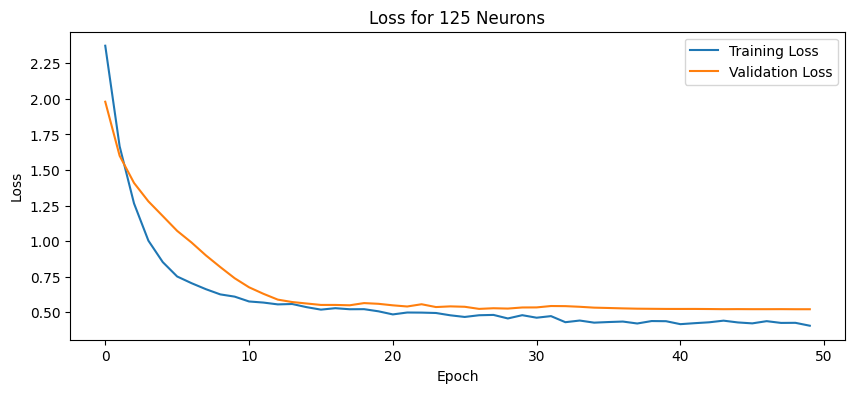

   Neuron Count  Validation Loss  Validation Accuracy  Precision    Recall  \
0            75         0.504124             0.885794   0.886039  0.885794   
1           100         0.489670             0.895543   0.895936  0.895543   
2           125         0.521390             0.883008   0.882347  0.883008   

   F1-Score  Support  
0  0.884585    718.0  
1  0.894484    718.0  
2  0.882056    718.0  


In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers
import tensorflow as tf

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Jumlah neuron yang akan diuji
neuron_counts = [75, 100, 125]
results = []

for neurons in neuron_counts:
    print(f"\nTraining with {neurons} neurons in LSTM layers.")

    # Kompilasi ulang model untuk setiap jumlah neuron
    model_LSTM_neuron = tf.keras.models.Sequential([
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(neurons, return_sequences=True, kernel_regularizer=regularizers.l2(0.001), dropout=0.3, input_shape=(X_train.shape[1], X_train.shape[2]))),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),  # Dropout tambahan
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(neurons // 2, kernel_regularizer=regularizers.l2(0.001), dropout=0.3)),  # Menggunakan setengah dari neuron
        tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        tf.keras.layers.Dropout(0.5),  # Dropout tambahan
        tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.0001))
    ])

    model_LSTM_neuron.compile(
        optimizer=tf.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # ReduceLROnPlateau callback
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

    # Latih model dengan jumlah neuron tertentu
    history = model_LSTM_neuron.fit(
        X_train, y_train,
        epochs=50,
        batch_size=64,  # Menggunakan batch terbaik hasil training sebelumnya
        validation_data=(X_val, y_val),
        callbacks=[reduce_lr]
    )

    # Evaluasi model
    val_loss, val_accuracy = model_LSTM_neuron.evaluate(X_val, y_val)

    # Prediksi label untuk data validasi
    y_val_pred_neu = model_LSTM_neuron.predict(X_val)
    y_val_pred_classes_neu = np.argmax(y_val_pred_neu, axis=1)  # Ambil kelas dengan probabilitas tertinggi
    y_val_classes_neu = np.argmax(y_val, axis=1)  # Mengambil kelas dari one-hot encoding

    # Hitung classification report
    report_LSTM_neuron = classification_report(y_val_classes_neu, y_val_pred_classes_neu, output_dict=True)

    # Simpan hasil
    results.append({
        'Neuron Count': neurons,
        'Validation Loss': val_loss,
        'Validation Accuracy': val_accuracy,
        'Precision': report_LSTM_neuron['weighted avg']['precision'],
        'Recall': report_LSTM_neuron['weighted avg']['recall'],
        'F1-Score': report_LSTM_neuron['weighted avg']['f1-score'],
        'Support': report_LSTM_neuron['weighted avg']['support']
    })

    # Plot confusion matrix
    print(f"Confusion Matrix for {neurons} Neurons:")
    plot_confusion_matrix(y_val_classes_neu, y_val_pred_classes_neu, labels=[0, 1, 2])

    # Plot training history
    print(f"Training and Validation Accuracy for {neurons} Neurons:")
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy for {neurons} Neurons')
    plt.legend()
    plt.show()

    print(f"Training and Validation Loss for {neurons} Neurons:")
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss for {neurons} Neurons')
    plt.legend()
    plt.show()

# Buat DataFrame untuk hasil
results_n_df = pd.DataFrame(results)

# Tampilkan hasil
print(results_n_df)


In [24]:
from IPython.display import display, HTML

styled_results = results_n_df.style.set_properties(**{'text-align': 'center'})
styled_results = styled_results.set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center')]}  # Center-align headers
])
display(HTML(styled_results.to_html()))

,Neuron Count,Validation Loss,Validation Accuracy,Precision,Recall,F1-Score,Support
0,75,0.504124,0.885794,0.886039,0.885794,0.884585,718.000000
1,100,0.489670,0.895543,0.895936,0.895543,0.894484,718.000000
2,125,0.521390,0.883008,0.882347,0.883008,0.882056,718.000000


In [25]:
best_result_index = results_n_df['Validation Accuracy'].idxmax()
best_result_df = results_n_df.loc[[best_result_index]]

# Display the best result
print("\nBest Result:")
display(best_result_df)


Best Result:


,Neuron Count,Validation Loss,Validation Accuracy,Precision,Recall,F1-Score,Support
1,100,0.48967,0.895543,0.895936,0.895543,0.894484,718.0


Melakukan pengujian untuk melihat perbandingan dari tiap epoch yang terdiri dari 75, 100, 150 epoch dengan neuron dan batch size terbaik dari hasil sebelumnya. Pengujian epoch bertujuan untuk mengatur jumlah siklus pelatihan model agar cukup untuk mempelajari pola dalam data tanpa menyebabkan overfitting. Dengan pengujian ini, model dapat mencapai akurasi tinggi pada data pelatihan dan, yang lebih penting, generalisasi yang baik pada data baru atau data validasi.


Training with 75 epochs, batch size: 64, and 100 neurons in LSTM layers.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/75
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 85ms/step - accuracy: 0.3579 - loss: 2.3966 - val_accuracy: 0.4986 - val_loss: 1.8634 - learning_rate: 5.0000e-04
Epoch 2/75
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.5236 - loss: 1.7138 - val_accuracy: 0.4011 - val_loss: 1.5482 - learning_rate: 5.0000e-04
Epoch 3/75
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6418 - loss: 1.3588 - val_accuracy: 0.3983 - val_loss: 1.4017 - learning_rate: 5.0000e-04
Epoch 4/75
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7353 - loss: 1.0898 - val_accuracy: 0.4735 - val_loss: 1.2928 - learning_rate: 5.0000e-04
Epoch 5/75
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7846 - loss: 0.8759 - val_accuracy: 0.5752 - val_loss: 1.1839 - learning_rate: 5.0000e-04
Epoch 6/75
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8093 - loss: 0.7814 - val_accuracy: 0.7618 - val_loss: 1.0671 - learning_rate: 5.0000e-04
Epoch 7/75
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.8432

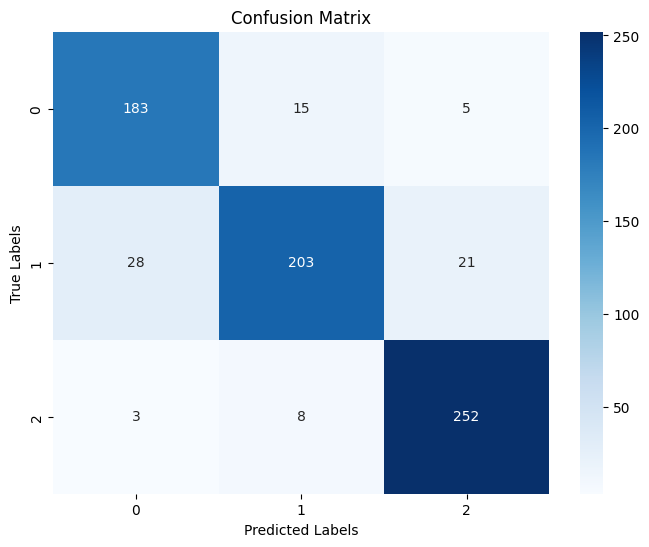

Training and Validation Accuracy for 75 Epochs:


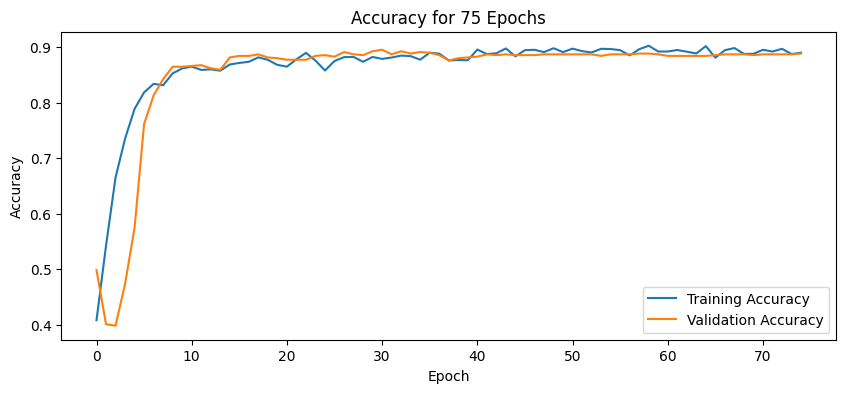

Training and Validation Loss for 75 Epochs:


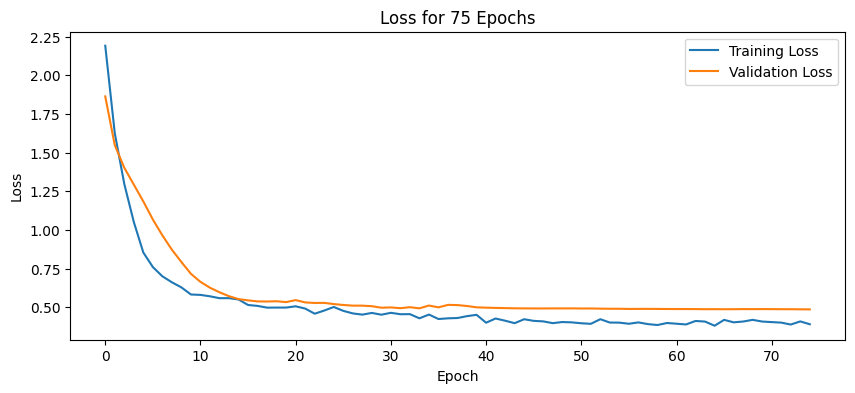


Training with 100 epochs, batch size: 64, and 100 neurons in LSTM layers.
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 0.3838 - loss: 2.4011 - val_accuracy: 0.4485 - val_loss: 1.8849 - learning_rate: 5.0000e-04
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.5332 - loss: 1.7024 - val_accuracy: 0.5669 - val_loss: 1.5722 - learning_rate: 5.0000e-04
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.6345 - loss: 1.3307 - val_accuracy: 0.5655 - val_loss: 1.4148 - learning_rate: 5.0000e-04
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.7658 - loss: 1.0487 - val_accuracy: 0.5279 - val_loss: 1.3046 - learning_rate: 5.0000e-04
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.7882 - loss: 0.8998 - val_accuracy: 0.6295 - val_loss: 1.1956 - learning_rate: 5.0000e-04
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8127 - loss: 0.8109 - val_accuracy: 0.6156 - val_loss: 1.1194 - learning_rate: 5.0000e-04
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8104 - l

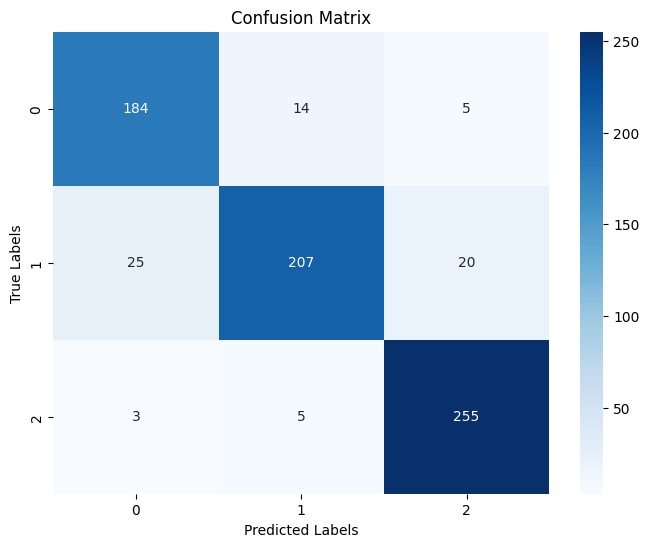

Training and Validation Accuracy for 100 Epochs:


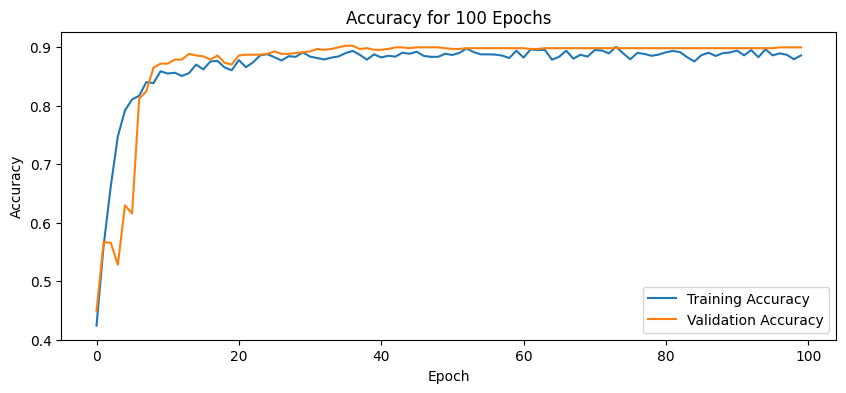

Training and Validation Loss for 100 Epochs:


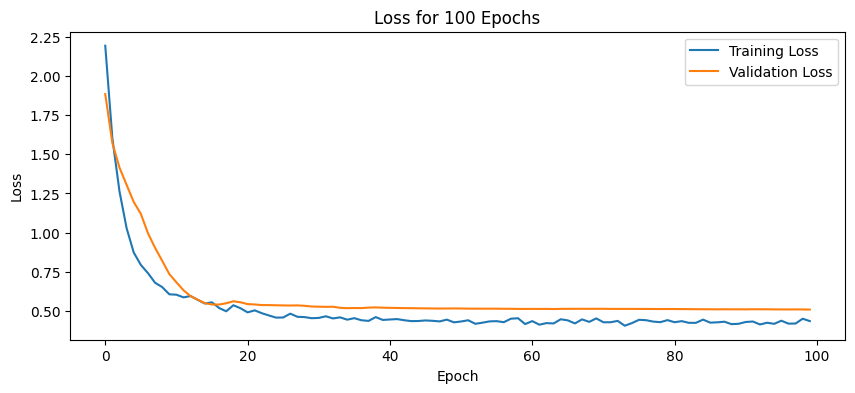


Training with 150 epochs, batch size: 64, and 100 neurons in LSTM layers.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.3569 - loss: 2.4027 - val_accuracy: 0.4136 - val_loss: 1.8726 - learning_rate: 5.0000e-04
Epoch 2/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.4949 - loss: 1.7284 - val_accuracy: 0.3510 - val_loss: 1.5619 - learning_rate: 5.0000e-04
Epoch 3/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.6027 - loss: 1.3925 - val_accuracy: 0.4540 - val_loss: 1.4105 - learning_rate: 5.0000e-04
Epoch 4/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.6794 - loss: 1.1569 - val_accuracy: 0.6838 - val_loss: 1.3043 - learning_rate: 5.0000e-04
Epoch 5/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7683 - loss: 0.9389 - val_accuracy: 0.7493 - val_loss: 1.1921 - learning_rate: 5.0000e-04
Epoch 6/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.8076 - loss: 0.7994 - val_accuracy: 0.7702 - val_loss: 1.0912 - learning_rate: 5.0000e-04
Epoch 7/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy:

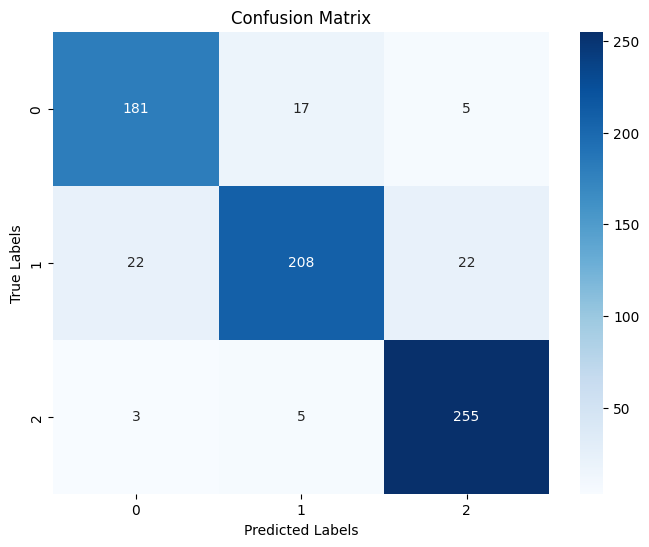

Training and Validation Accuracy for 150 Epochs:


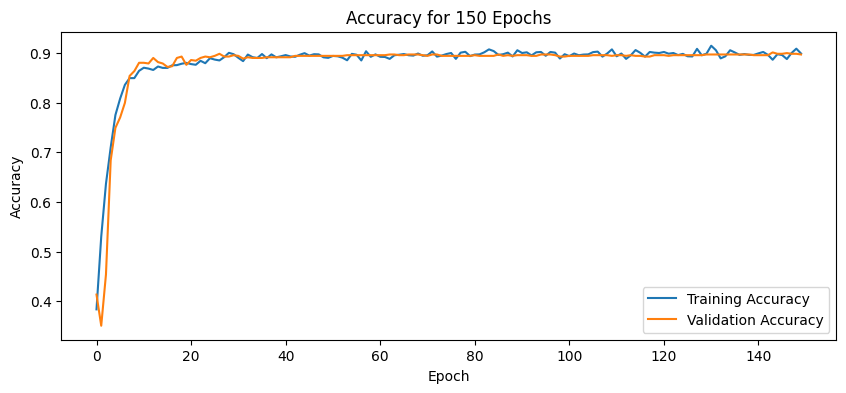

Training and Validation Loss for 150 Epochs:


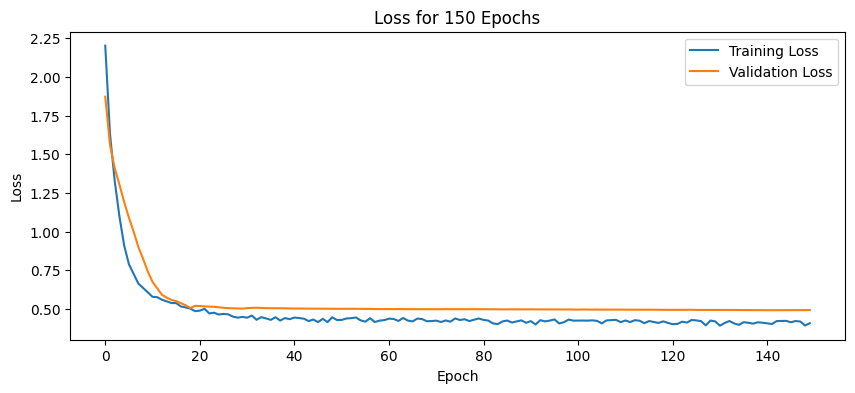

   Epochs  Validation Loss  Validation Accuracy  Precision    Recall  \
0      75         0.485684             0.888579   0.889067  0.888579   
1     100         0.507793             0.899721   0.900447  0.899721   
2     150         0.493124             0.896936   0.897046  0.896936   

   F1-Score  Support  
0  0.887503    718.0  
1  0.898727    718.0  
2  0.895928    718.0  


In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers
import tensorflow as tf

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Set jumlah neuron dan batch size dari hasil terbaik sebelumnya
neurons = 100
epochs_list = [75, 100, 150]
batch_size = 64
results = []

for epochs in epochs_list:
    print(f"\nTraining with {epochs} epochs, batch size: {batch_size}, and {neurons} neurons in LSTM layers.")

    # Kompilasi ulang model untuk setiap jumlah epoch
    model_nlp_ep = tf.keras.models.Sequential([
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(neurons, return_sequences=True, kernel_regularizer=regularizers.l2(0.001), dropout=0.3, input_shape=(X_train.shape[1], X_train.shape[2]))),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),  # Dropout tambahan
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(neurons // 2, kernel_regularizer=regularizers.l2(0.001), dropout=0.3)),
        tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        tf.keras.layers.Dropout(0.5),  # Dropout tambahan
        tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.0001))
    ])

    model_nlp_ep.compile(
        optimizer=tf.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # ReduceLROnPlateau callback
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

    # Latih model dengan jumlah epoch tertentu
    history = model_nlp_ep.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[reduce_lr]
    )

    # Evaluasi model
    val_loss, val_accuracy = model_nlp_ep.evaluate(X_val, y_val)

    # Prediksi label untuk data validasi
    y_val_pred_ep = model_nlp_ep.predict(X_val)
    y_val_pred_classes_ep = np.argmax(y_val_pred_ep, axis=1)  # Ambil kelas dengan probabilitas tertinggi
    y_val_classes_ep = np.argmax(y_val, axis=1)  # Mengambil kelas dari one-hot encoding

    # Hitung classification report
    report_ep = classification_report(y_val_classes_ep, y_val_pred_classes_ep, output_dict=True)

    # Simpan hasil
    results.append({
        'Epochs': epochs,
        'Validation Loss': val_loss,
        'Validation Accuracy': val_accuracy,
        'Precision': report_ep['weighted avg']['precision'],
        'Recall': report_ep['weighted avg']['recall'],
        'F1-Score': report_ep['weighted avg']['f1-score'],
        'Support': report_ep['weighted avg']['support']
    })

    # Plot confusion matrix
    print(f"Confusion Matrix for {epochs} Epochs:")
    plot_confusion_matrix(y_val_classes_ep, y_val_pred_classes_ep, labels=[0, 1, 2])

    # Plot training history for accuracy and loss
    print(f"Training and Validation Accuracy for {epochs} Epochs:")
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy for {epochs} Epochs')
    plt.legend()
    plt.show()

    print(f"Training and Validation Loss for {epochs} Epochs:")
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss for {epochs} Epochs')
    plt.legend()
    plt.show()

# Buat DataFrame untuk hasil
results_e_df = pd.DataFrame(results)

# Tampilkan hasil
print(results_e_df)

In [27]:
from IPython.display import display, HTML

styled_results = results_e_df.style.set_properties(**{'text-align': 'center'})
styled_results = styled_results.set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center')]}  # Center-align headers
])
display(HTML(styled_results.to_html()))

,Epochs,Validation Loss,Validation Accuracy,Precision,Recall,F1-Score,Support
0,75,0.485684,0.888579,0.889067,0.888579,0.887503,718.000000
1,100,0.507793,0.899721,0.900447,0.899721,0.898727,718.000000
2,150,0.493124,0.896936,0.897046,0.896936,0.895928,718.000000


In [28]:
best_result_index = results_e_df['Validation Accuracy'].idxmax()
best_result_df = results_e_df.loc[[best_result_index]]

# Display the best result
print("\nBest Result:")
display(best_result_df)


Best Result:


,Epochs,Validation Loss,Validation Accuracy,Precision,Recall,F1-Score,Support
1,100,0.507793,0.899721,0.900447,0.899721,0.898727,718.0


Model terbaik sudah didapatkan , saatnya melakukan pengujian pada model terbaik


Training with 100 epochs, batch size: 64, and 100 neurons in LSTM layers.
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - accuracy: 0.3801 - loss: 2.4014 - val_accuracy: 0.3705 - val_loss: 1.8896 - learning_rate: 5.0000e-04
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.5324 - loss: 1.7050 - val_accuracy: 0.6045 - val_loss: 1.5799 - learning_rate: 5.0000e-04
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6583 - loss: 1.3263 - val_accuracy: 0.5696 - val_loss: 1.4223 - learning_rate: 5.0000e-04
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7382 - loss: 1.0698 - val_accuracy: 0.6713 - val_loss: 1.3071 - learning_rate: 5.0000e-04
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7696 - loss: 0.9219 - val_accuracy: 0.7688 - val_loss: 1.1923 - learning_rate: 5.0000e-04
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7963 - loss: 0.8105 - val_accuracy: 0.8454 - val_loss: 1.0901 - learning_rate: 5.0000e-04
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8194 - lo

  Model  Validation Accuracy  Precision    Recall  F1-Score  Support
0  LSTM             0.885794    0.88517  0.885794  0.884586    718.0


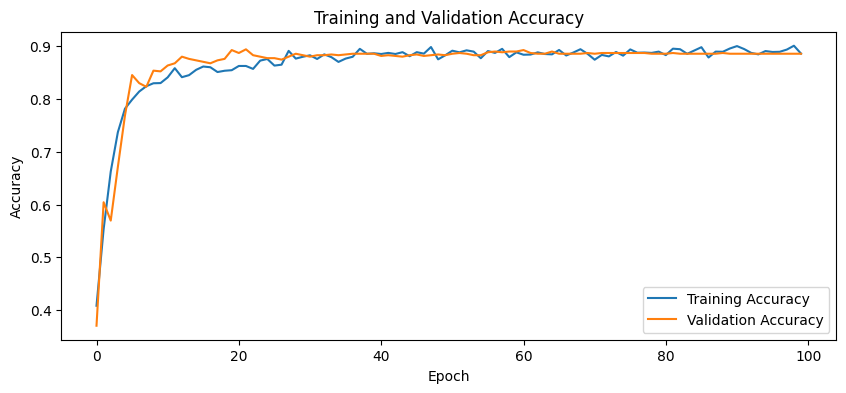

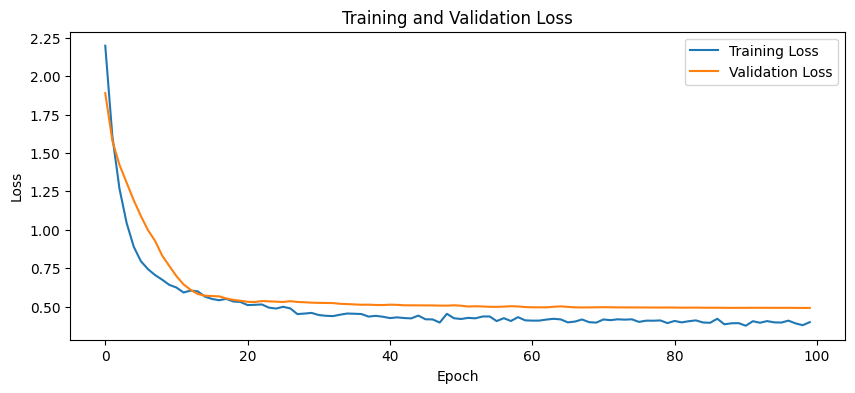

Confusion Matrix:


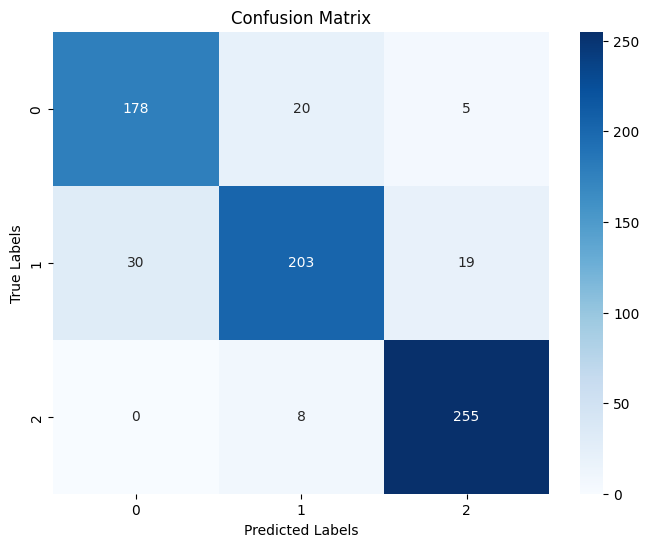

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers
import tensorflow as tf

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Parameter model terbaik
neurons = 100
epochs = 100
batch_size = 64
results = []

print(f"\nTraining with {epochs} epochs, batch size: {batch_size}, and {neurons} neurons in LSTM layers.")

# Kompilasi model dengan parameter yang telah ditentukan
model_nlp = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(neurons, return_sequences=True, kernel_regularizer=regularizers.l2(0.001), dropout=0.3, input_shape=(X_train.shape[1], X_train.shape[2]))),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),  # Dropout tambahan
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(neurons // 2, kernel_regularizer=regularizers.l2(0.001), dropout=0.3)),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(0.5),  # Dropout tambahan
    tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.0001))
])

model_nlp.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callback untuk pengurangan learning rate jika tidak ada peningkatan
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

# Latih model
history = model_nlp.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[reduce_lr]
)

# Evaluasi model
val_loss, val_accuracy = model_nlp.evaluate(X_val, y_val)

# Prediksi label untuk data validasi
y_val_pred = model_nlp.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

# Hitung classification report
report = classification_report(y_val_classes, y_val_pred_classes, output_dict=True)

# Simpan hasil ke dalam list

results.append({
    'Model': 'LSTM',
    'Validation Accuracy': val_accuracy,
    'Precision': report['weighted avg']['precision'],
    'Recall': report['weighted avg']['recall'],
    'F1-Score': report['weighted avg']['f1-score'],
    'Support': report['weighted avg']['support']
})

# Simpan model
model_nlp.save('model_nlp.h5')

# Buat DataFrame untuk hasil
results_df = pd.DataFrame(results)

# Tampilkan hasil
print(results_df)

# Plot akurasi selama pelatihan
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot loss selama pelatihan
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot confusion matrix
print("Confusion Matrix:")
plot_confusion_matrix(y_val_classes, y_val_pred_classes, labels=[0, 1, 2])


In [30]:
print("\Result:")
display(results_df)

\Result:


,Model,Validation Accuracy,Precision,Recall,F1-Score,Support
0,LSTM,0.885794,0.88517,0.885794,0.884586,718.0


# Menampilkan Wordcloud Untuk Tiap Sentimen

In [31]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
sentimen_negatif = df[df['label'] == 'Negative']['Stemming'].str.cat(sep=' ')
sentimen_positif = df[df['label'] == 'Positive']['Stemming'].str.cat(sep=' ')
sentimen_netral = df[df['label'] == 'Neutral']['Stemming'].str.cat(sep=' ')

In [32]:
def create_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, random_state=42, max_font_size=100, background_color='black').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

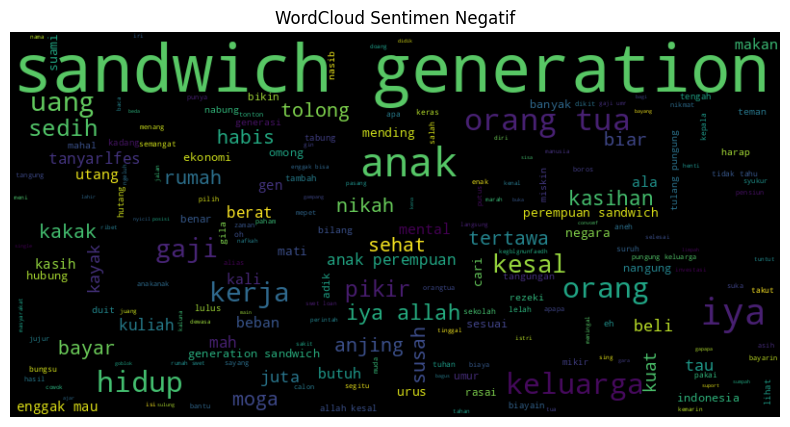

In [33]:
# Membuat WordCloud untuk sentimen negatif
create_wordcloud(sentimen_negatif, 'WordCloud Sentimen Negatif')

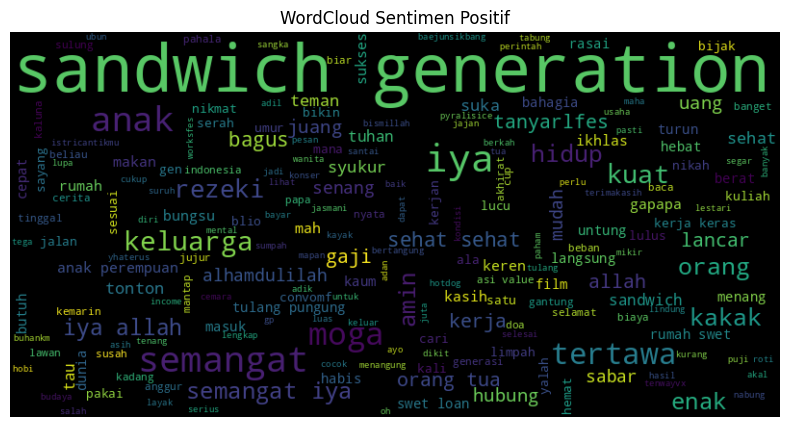

In [34]:
# Membuat WordCloud untuk sentimen negatif
create_wordcloud(sentimen_positif, 'WordCloud Sentimen Positif')

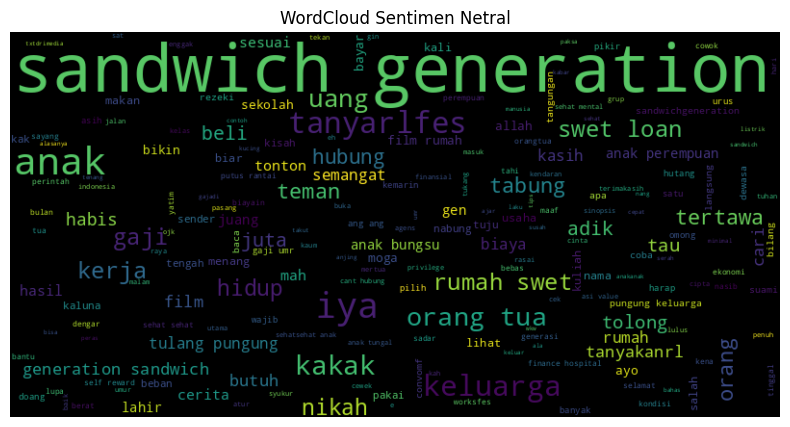

In [35]:
# Membuat WordCloud untuk sentimen negatif
create_wordcloud(sentimen_netral, 'WordCloud Sentimen Netral')

# Melakukan Test Untuk Memprediksi Teks Baru Dari Model Terbaik

In [36]:
# Memuat model yang telah disimpan

model_nlp_loaded = tf.keras.models.load_model('model_nlp.h5')

# Fungsi untuk memproses teks baru dan memprediksi label

def predict_new_text(model, label_encoder, vectorizer, new_text):
    # Memastikan new_text adalah list berisi string
    if isinstance(new_text, str):
        new_text = [new_text]  # Ubah menjadi list jika hanya satu kalimat

    # Vektorisasi teks baru
    new_text_vectorized = vectorizer.transform(new_text).toarray()

    # Bentuk ulang untuk input LSTM
    new_text_reshaped = new_text_vectorized.reshape((new_text_vectorized.shape[0], 1, new_text_vectorized.shape[1]))

    # Melakukan prediksi
    predictions = model.predict(new_text_reshaped)
    predicted_class = np.argmax(predictions, axis=1)

    # Kembalikan label yang sesuai
    predicted_label = label_encoder.inverse_transform(predicted_class)
    return predicted_label

# Penggunaan fungsi untuk memprediksi teks baru
new_input_texts = [
    "Kesal menjadi generasi sandwich",
    "Alhamdulilah masih kuat",
    "Tetap bersyukur kawan"
]

predicted_labels = [predict_new_text(model_nlp_loaded, label_encoder, vectorizer, text) for text in new_input_texts]

for text, label in zip(new_input_texts, predicted_labels):
    print(f"Predicted label for the input text '{text}': {label[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted label for the input text 'Kesal menjadi generasi sandwich': Negative
Predicted label for the input text 'Alhamdulilah masih kuat': Positive
Predicted label for the input text 'Tetap bersyukur kawan': Neutral


# Model Naive-Bayes

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

# Memuat Dataset dan Melakukan Pre-Processing Data

In [38]:
data = pd.read_csv('dataset_swch_roberta_ayame.csv',delimiter=';')
data

,Unnamed: 0,Stemming,label
0,0,shelaemeliana sehat iya sandwich generation,Neutral
1,1,film rumah swet loan recomended gusy nonton ta...,Neutral
2,2,tanyakanrl teman sandwich generation hedon,Neutral
3,3,kabar iya kakak kakak garuda soft spoken sandw...,Neutral
4,4,film bagus kali menang huhu misuhmisuhinkeluar...,Positive
...,...,...,...
1407,1407,idola perempuanperempuan dady isue sandwich ge...,Neutral
1408,1408,convomf anak of kursus sandwich generation,Neutral
1409,1409,convomf anak of kursus sandwich generation,Neutral
1410,1410,inipita biar enak bada badane suka gel gel san...,Positive


In [39]:
del data ['Unnamed: 0']
data

,Stemming,label
0,shelaemeliana sehat iya sandwich generation,Neutral
1,film rumah swet loan recomended gusy nonton ta...,Neutral
2,tanyakanrl teman sandwich generation hedon,Neutral
3,kabar iya kakak kakak garuda soft spoken sandw...,Neutral
4,film bagus kali menang huhu misuhmisuhinkeluar...,Positive
...,...,...
1407,idola perempuanperempuan dady isue sandwich ge...,Neutral
1408,convomf anak of kursus sandwich generation,Neutral
1409,convomf anak of kursus sandwich generation,Neutral
1410,inipita biar enak bada badane suka gel gel san...,Positive


In [40]:
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
data

,Stemming,label
0,shelaemeliana sehat iya sandwich generation,Neutral
1,film rumah swet loan recomended gusy nonton ta...,Neutral
2,tanyakanrl teman sandwich generation hedon,Neutral
3,kabar iya kakak kakak garuda soft spoken sandw...,Neutral
4,film bagus kali menang huhu misuhmisuhinkeluar...,Positive
...,...,...
1407,idola perempuanperempuan dady isue sandwich ge...,Neutral
1408,convomf anak of kursus sandwich generation,Neutral
1409,convomf anak of kursus sandwich generation,Neutral
1410,inipita biar enak bada badane suka gel gel san...,Positive


In [41]:
data['label'].value_counts()

,count
label,
Neutral,640
Negative,513
Positive,259


# Proses Data Augmentatif
Proses ini dilakukan untuk memperkaya dataset dalam proses pembelajaran mesin untuk membuat prediksi yang lebih akurat

In [42]:
def synonym_replacement(text):
    words = nltk.word_tokenize(text)  # Tokenisasi kalimat menjadi kata-kata
    new_words = words.copy()

    for word in words:
        # Mengambil sinonim dari WordNet
        synonyms = wordnet.synsets(word)
        if synonyms:
            # Ambil satu sinonim secara acak
            synonym = random.choice(synonyms).lemmas()[0].name()  # Ambil sinonim pertama
            new_words = [synonym if w == word else w for w in new_words]

    return ' '.join(new_words)

#Lakukan augmentasi pada dataset
augmented_texts = []
for text in data['Stemming']:
    augmented_texts.append(synonym_replacement(text))

#Buat DataFrame baru untuk menampung teks augmented
augmented_data = pd.DataFrame({
    'Stemming': augmented_texts,
    'label': data['label']  # Tetap menggunakan label asli
})

#Gabungkan dengan DataFrame asli
combined_data = pd.concat([data, augmented_data], ignore_index=True)

#Tampilkan hasil augmentasi
print(combined_data)

                                               Stemming     label
0           shelaemeliana sehat iya sandwich generation   Neutral
1     film rumah swet loan recomended gusy nonton ta...   Neutral
2            tanyakanrl teman sandwich generation hedon   Neutral
3     kabar iya kakak kakak garuda soft spoken sandw...   Neutral
4     film bagus kali menang huhu misuhmisuhinkeluar...  Positive
...                                                 ...       ...
2819  idola perempuanperempuan dady isue sandwich co...   Neutral
2820         convomf anak of kursus sandwich generation   Neutral
2821            convomf anak of kursus sandwich genesis   Neutral
2822  inipita biar enak bada badane suka gel gel san...  Positive
2823  mending kost actinium not actinium asumsi gaji...  Negative

[2824 rows x 2 columns]


# Konversi Data Teks Agar Menjadi Numerik

In [43]:
#Konversi label menjadi format numerik
X= combined_data['Stemming']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(combined_data['label'])
y_encoded

array([1, 1, 1, ..., 1, 2, 0])

In [44]:
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
#Menggunakan TF-IDF untuk merubah teks menjadi vektor
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

# Oversampling Data
Proses ini dilakukan untuk melakukan pemerataan distribusi dari label.

In [46]:
from imblearn.over_sampling import SMOTE
#Inisialisasi SMOTE
smote = SMOTE(sampling_strategy='minority')
#Terapkan SMOTE pada data pelatihan
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf, y_train)
pd.value_counts(y_smote)

<ipython-input-46-ce294e693f5b>:6: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(y_smote)


,count
1,1280
2,1280
0,1026


<ipython-input-47-01176d876ac5>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  label_counts_smote = pd.value_counts(y_smote)


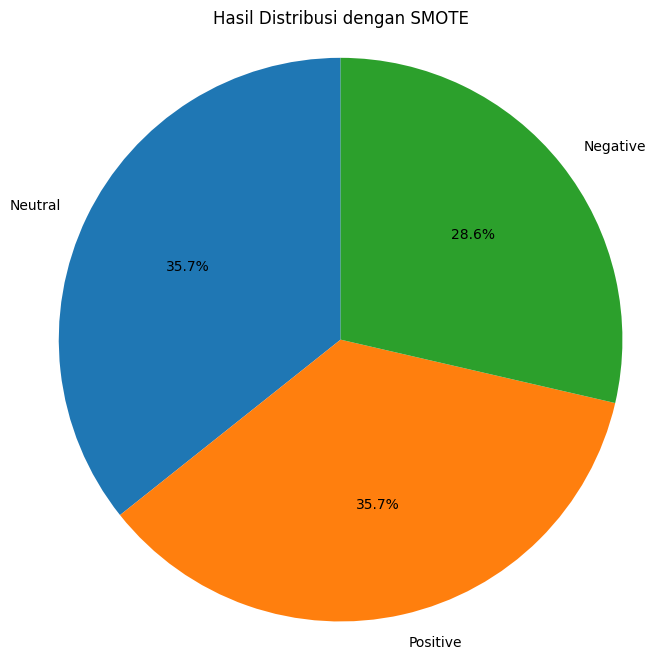

In [47]:
label_counts_smote = pd.value_counts(y_smote)
labels_original = label_encoder.inverse_transform(label_counts_smote.index)

plt.figure(figsize=(8, 8))
plt.pie(label_counts_smote, labels=labels_original, autopct='%1.1f%%', startangle=90)
plt.title('Hasil Distribusi dengan SMOTE')
plt.axis('equal')
plt.show()

# Modelling Naive-Bayes dengan Library MultinomialNB

Best alpha: 0.1
Naive Bayes Classification Report:
               precision    recall  f1-score   support

    Negative       0.87      0.85      0.86       205
     Neutral       0.88      0.86      0.87       256
    Positive       0.78      0.87      0.82       104

    accuracy                           0.86       565
   macro avg       0.84      0.86      0.85       565
weighted avg       0.86      0.86      0.86       565



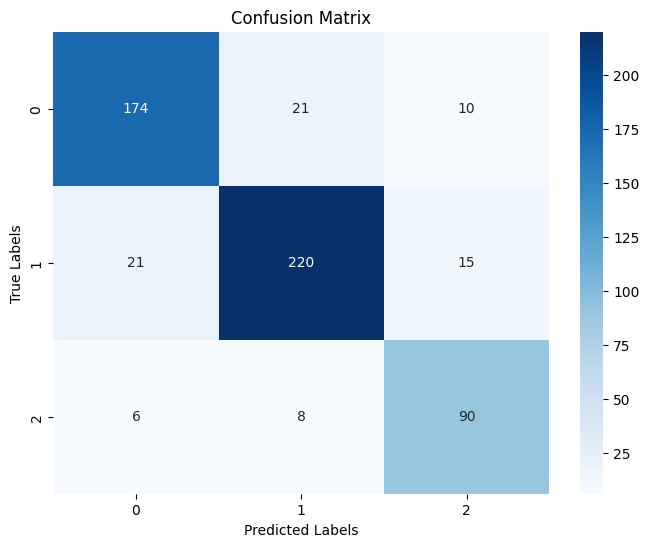

Naive Bayes Mean CV Accuracy: 0.8783534305051353


In [48]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB
#Inisialisasi model Naive Bayes
model_nb = MultinomialNB()

# Hyperparameter tuning alpha yang mengontrol smoothing pada model
param_grid = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]}
model_nb = MultinomialNB()
grid_search = GridSearchCV(model_nb, param_grid, cv=5)
grid_search.fit(X_train_balanced, y_train_balanced)

# Parameter terbaik Naive Bayes
print(f"Best alpha: {grid_search.best_params_['alpha']}")
model_nb = grid_search.best_estimator_

# Prediksi Naive Bayes
y_val_pred_nb = model_nb.predict(X_val_tfidf)

# Laporan klasifikasi Naive Bayes
print("Naive Bayes Classification Report:\n", classification_report(y_val, y_val_pred_nb, target_names=label_encoder.classes_))

# Confusion Matrix Naive Bayes
plot_confusion_matrix(y_val, y_val_pred_nb, labels=[0, 1, 2])

# Cross-validation Naive Bayes
cv_scores = cross_val_score(model_nb, X_train_balanced, y_train_balanced, cv=5)
print(f"Naive Bayes Mean CV Accuracy: {cv_scores.mean()}")

# Hasil Naive Bayes
report_nb = classification_report(y_val, y_val_pred_nb, output_dict=True)
results.append({
    'Model': 'Naive Bayes',
    'Validation Accuracy': accuracy_score(y_val, y_val_pred_nb),
    'Precision': report_nb['weighted avg']['precision'],
    'Recall': report_nb['weighted avg']['recall'],
    'F1-Score': report_nb['weighted avg']['f1-score'],
    'Support': report_nb['weighted avg']['support']
})


# Perbandingan Model LSTM dan Naive-Bayes

In [49]:
# DataFrame Hasil
results_df = pd.DataFrame(results)
print(results_df)

         Model  Validation Accuracy  Precision    Recall  F1-Score  Support
0         LSTM             0.885794   0.885170  0.885794  0.884586    718.0
1  Naive Bayes             0.856637   0.858476  0.856637  0.857068    565.0


# Kesimpulan
Dari kedua model dapat disimpulkan bahwa model LSTM masih lebih unggul.